# Step 1: Data Cleaning 
This step is taken care of in the accompanying preprocessing notebook. That notebook includes the details for each dataset and our cleaning process.

In [931]:
import cv2
import time
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

import torchvision

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import albumentations as A
import albumentations
from albumentations.pytorch import ToTensorV2

In [932]:
# reading in the data 
data_path = 'images_rs'
df = pd.read_csv('/Users/michellejanneycoyle/Desktop/DL_Assignments/Object_Detection_DL/Data/train_labels_.csv')
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


In [933]:
# Sample Image
path = data_path + '/' + df.iloc[0]['filename']
img = cv2.imread(path)
img.shape

(128, 128, 3)

In [934]:
def display_imgbb(img, xmin, ymin, xmax, ymax):
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img)

    # Create a Rectangle patch
    rect = patches.Rectangle((xmin,ymin), (xmax - xmin) , (ymax - ymin) , linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [935]:
# smallest w,h
df['width'].min(), df['height'].min()

(178, 154)

In [938]:
# Bounding box for sample image
x0 = df.iloc[0]['xmin_rs']
y0 = df.iloc[0]['ymin_rs']
x1 = df.iloc[0]['xmax_rs']
y1 = df.iloc[0]['ymax_rs']
(x0,y0), (x1,y1)

((46.94980694980695, 39.58762886597938),
 (82.53281853281854, 77.85567010309278))

See resized image below 

In [937]:
# Rescale bounding box in preparation for rescaling images
image_size = 128
df['xmin_rs'] = df['xmin']*image_size/df['width']
df['xmax_rs'] = df['xmax']*image_size/df['width']
df['ymin_rs'] = df['ymin']*image_size/df['height']
df['ymax_rs'] = df['ymax']*image_size/df['height']

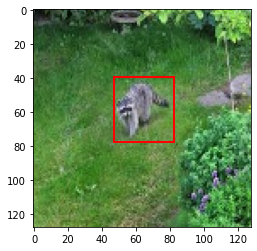

In [939]:
display_imgbb(img,x0,y0,x1,y1)

In [940]:
# Images with >1 raccoon, remove to simplify model
new = pd.DataFrame(df.filename.value_counts() > 1)
new = new.reset_index()
new = new[new['filename'] == True]
for_removal = list(new['index'].values)
len(for_removal)

12

In [941]:
# Images with 1 raccoon only
df = df[~df['filename'].isin(for_removal)]
len(df)

148

# PART ONE: Object Detection 

# Step 2: PyTorch Dataset and Data Augmentation 

In this step we create a **PyTorch Dataset**. Creating a PyTorch dataset is essential for creating any working model in PyTorch. The dataset comes with a number of helpful features and will allow your data to be automatically be split into training batches. Each custom dataset must include an init function, a len function, and a getitem function. Datasets are also helpful because you can perform data augmentation procedures within them.

Below you will see that our dataset includes the basic operations discussed above, and randomly augments some of the images passed through it. For data augmentation we decided to use the **albumentations library**. This library has a number of helpful features that allow you to easily augment images in a pipeline structure. In our dataset we choose to randomly **vertically flip** and **horizontally flip** our images 

In [966]:
class RaccoonDataset(Dataset):
    def __init__(self, df, root, augment=True):
        # Dataframe with bounding boxes
        self.df = df
        self.root = root
        
        # define the transformation
        # this transformation pipeline will randomly apply vertical flips, horizontal flips
        # to images and to bounding boxes 
        if augment == True:
            self.transforms = A.Compose([
                A.augmentations.transforms.VerticalFlip(p=.5),
                A.augmentations.transforms.HorizontalFlip(p=.5),
#                 A.augmentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()], bbox_params = A.BboxParams(format='pascal_voc', label_fields=['class_labels'])) 
        else:
            self.transforms = A.Compose([
#                 A.augmentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()], bbox_params = A.BboxParams(format='pascal_voc', label_fields=['class_labels']))
        
    def __len__(self):
        return len(self.df) # this only works if 1:1 image:label
    
    def __getitem__(self, idx):
        # gathering image information from datafiels 
        row = self.df.iloc[idx]
        fname = row['filename']
        img_path = root + '/' + fname
        img = cv2.imread(img_path)
        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Get bounding box coordinates ()
        xmin, ymin = tuple(list(row[['xmin_rs','ymin_rs']].values))
        xmax, ymax = tuple(list(row[['xmax_rs','ymax_rs']].values))
        
        # "normalizing" the bounding boxes to the same size as the image
        bbox = [[xmin/128,ymin/128,xmax/128,ymax/128]]
        class_labels = [row['class']]
        
        # passing image and bounding box values through the albumentations pipeline 
        transformed = self.transforms(image=img.astype(np.uint8),bboxes=bbox, class_labels=class_labels)
        img = transformed['image'].float()
        bbox = torch.tensor(transformed['bboxes'][0])
        class_labels = transformed['class_labels']
        
        return img, bbox

In [967]:
root = '/Users/michellejanneycoyle/Desktop/DL_Assignments/Object_Detection_DL/Data/Racoon Images/images_rs'
train_ds = RaccoonDataset(train, root)
valid_ds = RaccoonDataset(valid, root)

### Passing Data through a dataloader 
This will split your data into batches to pass through the model 

In [968]:
train_dl = DataLoader(train_ds, batch_size=10, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=10, shuffle=False)

### Function for running the model

Below is the framework for running the model that we will employ throughout this notebook (with slight changes). Here you can see the loss function is defined as MSELoss. We are running the model for **25 Epochs**. 

In [969]:
def run_model(model):
    loss_fun = nn.MSELoss()
    for epoch in range(25):
        # Train
        train_loss = 0
        for x, y in train_dl:
            model.train()
            y_pred = model(x)
            loss = loss_fun(y.float(), y_pred.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.shape[0]
            
        # Valid
        val_loss = 0
        for x, y in valid_dl:
            model.eval()
            y_pred = model(x)
            loss = loss_fun(y.float(), y_pred.float())
            val_loss += loss.item() * x.shape[0]
        if epoch % 5 == 0:
            print(f'Epoch {epoch} - Train loss: {round(train_loss/len(train),4)}  Valid loss: {round(val_loss/len(valid),4)}')    
            print()

# Step 3: Building a Basic Model 

For this exploration we choose to experiment with a basic **Convolutional Neural Network (CNN)**. Our model has four convolutional layers with pooling between. We also use relu as our activation function and two linear layers at the end. Our final linear layer outputs a tensor with 4 predictions representing our bounding box coordinates.

For our first round of testing we use **MSE loss**. In the next section we will use Intersection over Union loss and compare the outputs of each model. 

In [970]:
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        
        # same padding!
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=3, padding=1)
        
        self.linear1 = nn.Linear(256, 100)
        self.linear2 = nn.Linear(100, 4)
        
        # pooling
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # activation
        self.relu = nn.ReLU()
        self.unroll = nn.Flatten()
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv4(x)
        
        x = self.relu(x)
        
        # unroll x for FC layer
        x = self.linear1(self.unroll(x))
        x = self.relu(x)
        x = self.linear2(x)
        
        return x

In [972]:
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
model = CNN1()
run_model(model)

Epoch 0 - Train loss: 7084.5129  Valid loss: 8603.9487

Epoch 5 - Train loss: 8535.4121  Valid loss: 9377.8351

Epoch 10 - Train loss: 8049.8644  Valid loss: 8304.4958

Epoch 15 - Train loss: 7578.0436  Valid loss: 7253.4318

Epoch 20 - Train loss: 7632.0183  Valid loss: 6449.6523



## Step 4: Adding Batch Normalization

We noticed that the model above seems to have some difficulty learning the bounding boxes (i.e. the train and validation loss remain high and seem to jump around even with a very small learning rate). Therefore, we tried **batch normalization**. Batch Normalization is a common normalization technique used to prevent overfitting/learning unnecessary or incorrect patterns in the data. One important thing to keep in mind when using batch normalization is to use the **BatchNorm2d** function - this will handle image inputs that BatchNorm1d cannot handle. 

As you can see below, it looks like batch normalization did not work in this case. Unfortunately, we were unable to discover the cause of this issue. As with many things in DL this project is full of trial and error. 

In [973]:
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        
        # same padding!
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        # doing this to shrink size enough!
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=3, padding=1)
        
        self.linear1 = nn.Linear(256, 100)
        
        # read documentation for CrossEntropy Loss!
        self.linear2 = nn.Linear(100, 4)
        
        # pooling
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # activation
        self.relu = nn.ReLU()
        
        # for unrolling into FC layer
        self.unroll = nn.Flatten()
        
        # using 2d because we are using images! input should be the size of out channels 
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)


        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv4(x)
        
        x = self.relu(x)
        
        # unroll x for FC layer
        x = self.linear1(self.unroll(x))
        x = self.relu(x)
        x = self.linear2(x)
        
        return x

model = CNN()

In [974]:
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
model = CNN2()
run_model(model)

Epoch 0 - Train loss: 7854.0781  Valid loss: 7315.1471

Epoch 5 - Train loss: 8128.8987  Valid loss: 6230.2537

Epoch 10 - Train loss: 7302.6576  Valid loss: 7313.7482

Epoch 15 - Train loss: 7786.9428  Valid loss: 8127.1346

Epoch 20 - Train loss: 9506.9601  Valid loss: 7857.0988



# Step 5: IOU as Loss Function

**Intersection over Union (IoU)** is a helpful loss function and metric that can be used when training and evaluating the performance of an object detection model. The basic idea is that IoU measures the area shared between the ground truth bounding box and the predicted bounding box. If you look below you will see our adapted IoU function (citation in comment). 

In [ ]:
# Code adapted from https://github.com/t-vi/pytorch-tvmisc/blob/master/misc/pytorch_automatic_optimization_jit.ipynb
def ratio_iou(y_pred_bbox, bbox):
    # bbox comes in order of x1, y1, x2, y2
    iou = 0
    for i in range(bbox.shape[0]):
        x1 = y_pred_bbox[i][0] # top left x coordinate, x1
        y1 = y_pred_bbox[i][3] # top left y coordinate, y2 
        w1 = torch.abs(y_pred_bbox[i][2] - y_pred_bbox[i])[0] # x2 - x1
        h1 = torch.abs(y_pred_bbox[i][3] - y_pred_bbox[i])[1] # y2 - y1
        x2 = bbox[i][0]
        y2 = bbox[i][3]
        w2 = torch.abs(bbox[i][2] - bbox[i][0])
        h2 = torch.abs(bbox[i][3] - bbox[i][1])
        xi = torch.max(x1, x2)                                 # Intersection
        yi = torch.max(y1, y2)
        wi = torch.clamp(torch.min(x1+w1, x2+w2) - xi, min=0)
        wi = torch.min(x1+w1, x2+w2)
        hi = torch.clamp(torch.min(y1+h1, y2+h2) - yi, min=0)
        print(torch.min(x1+w1, x2+w2) - xi)
        print(torch.clamp(torch.min(x1+w1, x2+w2) - xi, min=0))
        area_i = wi * hi                                       # Area Intersection 
        area_u = w1 * h1 + w2 * h2 - wi * hi                   # Area Union
#         print(area_i)
        iou += (area_i / torch.clamp(area_u, min=1e-5))
        return iou/bbox.shape[0]

def ratio_iou_loss(y_pred_bbox, bbox):
    return -ratio_iou(y_pred_bbox, bbox)

In [894]:
model = CNN1()
y_pred = model(x)

In [895]:
y_pred.size(), y.size()

(torch.Size([10, 4]), torch.Size([10, 4]))

In [896]:
loss = ratio_iou_loss(y, y_pred)
loss

tensor(-125.8052, dtype=torch.float64, grad_fn=<SubBackward0>)
tensor(0., dtype=torch.float64, grad_fn=<ClampBackward>)


tensor(-0., dtype=torch.float64, grad_fn=<NegBackward>)

# PART TWO: Classification and Object Detection

In this repository we also want to provide the ground work for creating a **multi-task** model. Namely a model that can predict if a raccoon is present or not as well at locating the raccoon if one is detected. In order to create this model we combined the original raccoon dataset with a dataset that includes images of other animals. Details on the second dataset and preprocessing can be found in the preprocessing notebook. 

In [999]:
# reading in cleaned, and combined dataset (see preprocessing notebook) 
train_df = pd.read_csv("combined_train.csv")
valid_df = pd.read_csv("combined_valid.csv")
# valid_df = valid_df['filename', 'width', 'height', 'class', 'xmin', 'ymin', 
#                     'xmax', 'ymax', 'xmin_rs', 'xmax_rs', 'ymin_rs', 'ymax_rs']
valid_df = valid_df.reset_index()
train_df = train_df.reset_index()

In [1000]:
train_df

,index,Unnamed: 0,filename,width,height,class,xmin,ymin,xmax,ymax,xmin_rs,xmax_rs,ymin_rs,ymax_rs
0,0,0,raccoon-17.jpg,259.0,194.0,raccoon,95.0,60.0,167.0,118.0,46.949807,82.532819,39.587629,77.855670
1,1,1,raccoon-11.jpg,660.0,432.0,raccoon,3.0,1.0,461.0,431.0,0.581818,89.406061,0.296296,127.703704
2,2,2,raccoon-60.jpg,273.0,185.0,raccoon,58.0,33.0,197.0,127.0,27.194139,92.366300,22.832432,87.870270
3,3,3,raccoon-200.jpg,261.0,193.0,raccoon,107.0,10.0,249.0,166.0,52.475096,122.114943,6.632124,110.093264
4,4,4,raccoon-141.jpg,249.0,202.0,raccoon,1.0,1.0,154.0,176.0,0.514056,79.164659,0.633663,111.524752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,231,231,flickr_wild_002748.jpg,NaN,NaN,wild,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
232,232,232,pixabay_wild_000700.jpg,NaN,NaN,wild,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
233,233,233,flickr_wild_000289.jpg,NaN,NaN,wild,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
234,234,234,pixabay_wild_000024.jpg,NaN,NaN,wild,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000


In [1019]:
class RaccoonDataset(Dataset):
    def __init__(self, df, root, augment=True):
        # Dataframe with bounding boxes
        self.df = df
        self.root = root
        self.label_dict = {'raccoon':1, 'wild':0}
        # define the transformation
        # this transformation pipeline will randomly apply vertical flips, horizontal flips
        # to images and to bounding boxes 
        if augment == True:
            self.transforms = A.Compose([
                A.augmentations.transforms.VerticalFlip(p=.5),
                A.augmentations.transforms.HorizontalFlip(p=.5),
                ToTensorV2()], bbox_params = A.BboxParams(format='pascal_voc', label_fields=['class_labels'])) 
        else:
            self.transforms = A.Compose([
                ToTensorV2()], bbox_params = A.BboxParams(format='pascal_voc', label_fields=['class_labels']))
        
    def __len__(self):
        return len(self.df) # this only works if 1:1 image:label
    
    def __getitem__(self, idx):
        # gathering image information from datafiels 
        row = self.df.iloc[idx]
        fname = row['filename']
        img_path = root + '/' + fname
        img = cv2.imread(img_path)
        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Get bounding box coordinates ()
        xmin, ymin = tuple(list(row[['xmin_rs','ymin_rs']].values))
        xmax, ymax = tuple(list(row[['xmax_rs','ymax_rs']].values))
        
        # "normalizing" the bounding boxes to the same size as the image
        bbox = [[xmin/128,ymin/128,xmax/128,ymax/128]]
        class_labels = [row['class']]
        
        # passing image and bounding box values through the albumentations pipeline 
        transformed = self.transforms(image=img.astype(np.uint8),bboxes=bbox, class_labels=class_labels)
        img = transformed['image'].float()
        bbox = torch.tensor(transformed['bboxes'][0])
        class_labels = transformed['class_labels']
        label = self.label_dict['raccoon']
        return img, label, bbox

In [1014]:
root = '/Users/michellejanneycoyle/Desktop/Object_Detection_DL/combined_rs'
train_ds = RaccoonDataset(train, root)
valid_ds = RaccoonDataset(valid, root)

In [1021]:
train_df

,index,Unnamed: 0,filename,width,height,class,xmin,ymin,xmax,ymax,xmin_rs,xmax_rs,ymin_rs,ymax_rs
0,0,0,raccoon-17.jpg,259.0,194.0,raccoon,95.0,60.0,167.0,118.0,46.949807,82.532819,39.587629,77.855670
1,1,1,raccoon-11.jpg,660.0,432.0,raccoon,3.0,1.0,461.0,431.0,0.581818,89.406061,0.296296,127.703704
2,2,2,raccoon-60.jpg,273.0,185.0,raccoon,58.0,33.0,197.0,127.0,27.194139,92.366300,22.832432,87.870270
3,3,3,raccoon-200.jpg,261.0,193.0,raccoon,107.0,10.0,249.0,166.0,52.475096,122.114943,6.632124,110.093264
4,4,4,raccoon-141.jpg,249.0,202.0,raccoon,1.0,1.0,154.0,176.0,0.514056,79.164659,0.633663,111.524752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,231,231,flickr_wild_002748.jpg,NaN,NaN,wild,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
232,232,232,pixabay_wild_000700.jpg,NaN,NaN,wild,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
233,233,233,flickr_wild_000289.jpg,NaN,NaN,wild,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
234,234,234,pixabay_wild_000024.jpg,NaN,NaN,wild,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000


In [1020]:
x, y, bbox = next(iter(train_ds))

In [1017]:
train_dl = DataLoader(train_ds, batch_size=10, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=10, shuffle=False)

In [ ]:
def train_model(train_dl, valid_dl, num_epochs, model, optimizer, loss_weight):
    for epoch in range(num_epochs):
        # Train
        train_loss = 0
        for x, y, bbox in train_dl:
            model.train()
            
            y_pred = model(x)
            # splitting y_pred into two for respective loss functions
            # indexing is different in pytorch
            y_pred = torch.split(y_pred, 196, dim=1)
            y_pred_class = y_pred[0] # Keep it in this form because CrossEntorpyLoss includes Softmax
            y_pred_bbox = y_pred[1]
            
            loss = class_loss(input=y_pred_class, target=y) + (loss_weight*bbox_loss(input=y_pred_bbox, target=bbox))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.shape[0]
            
        # Valid
        val_loss = 0
        num_correct = []
        iou_scores = []
        for x, y, bbox in valid_dl:
            
            model.eval()
            
            y_pred = model(x)
            y_pred = torch.split(y_pred, 196, dim=1)
            y_pred_class = y_pred[0]
            y_pred_bbox = y_pred[1]
            loss = class_loss(input=y_pred_class, target=y) + (loss_weight*bbox_loss(input=y_pred_bbox, target=bbox))
            val_loss += loss.item() * x.shape[0]
            y_pred_class = torch.argmax(y_pred_class, dim=1) # Find the index where the max occurs to get the most likely class
            correct = y_pred_class.eq(y.data).sum().item()
            num_correct.append(correct)
#             iou = ratio_iou(y_pred_bbox, bbox)
#             iou_scores.append(iou.item())

        print(f'Epoch {epoch}')
        print(f'Train loss: {round(train_loss/len(df_train),4)}  Valid loss: {round(val_loss/len(df_valid),4)}') 
        print('Valid Accuracy', sum(num_correct)/len(df_valid))
#         print('IoU score', round(sum(iou_scores)/len(iou_scores),4))